Author: Salo Elia  
Date: January 2022

In [1]:
!pip install livelossplot

In [2]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 98 kB 3.8 MB/s 


Imports

In [3]:
import os
import pandas as pd
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense, Dropout,GRU,Embedding,Input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from livelossplot import PlotLossesKeras
from tqdm import tqdm
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
import keras_tuner as kt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#Overview

In this notebook, I will try to create models that will generate Beatles-style lyrics, using RNNs, GRUs and LSTMs.
I will examine different architectures and look for the ideal hyperparameters for them. The data contains all the Beatles songs from all the years, which were written by the four band members. I will train the models on the data, as it is divided using two methods which will be detailed below. Graphs will be displayed and words written by the model will be displayed and examined as well, in the hope that they will be syntactically sensible and perhaps beautiful to humans.
This notebook is also for anyone who wants to create projects that are related to text generation, in the hope that it can be useful for them.





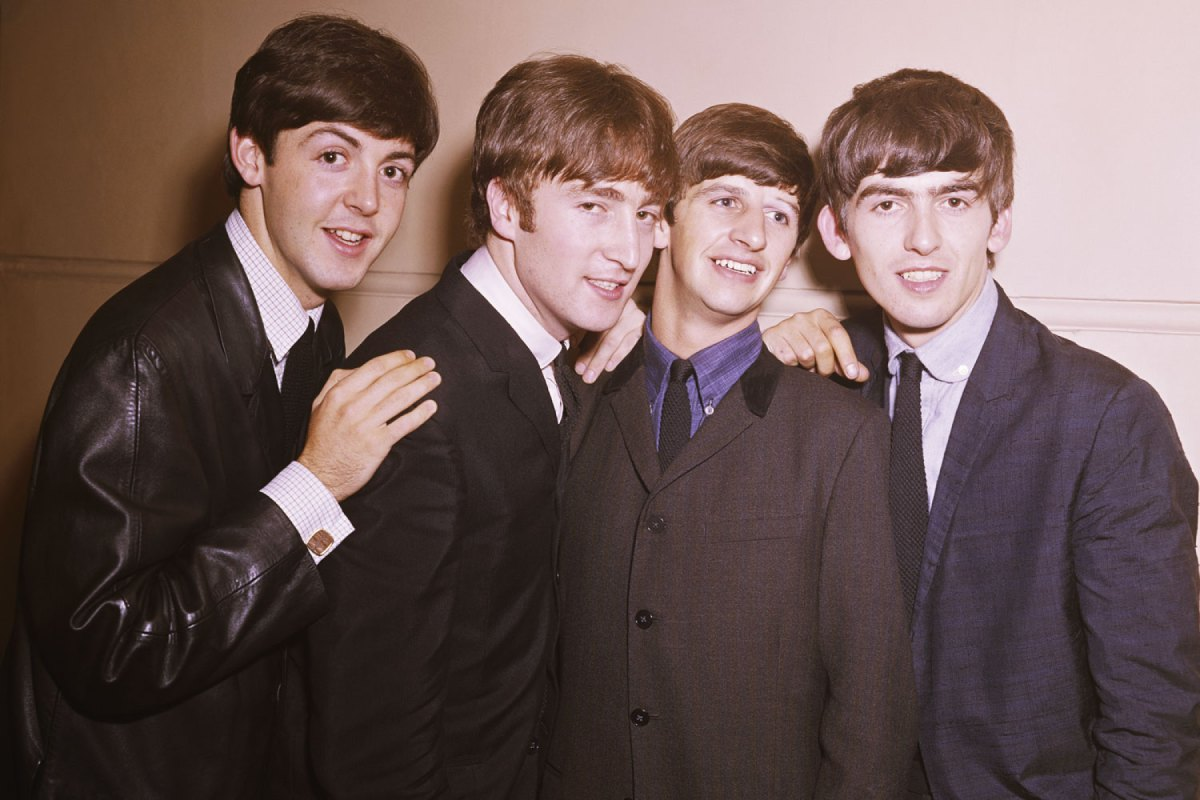

#The Data

The data contains all the Beatles songs written over the years. The data is divided into 4 columns: Lyrics, Song Title, Album, and Year of release. The data was created manually by me when I used the site - http://toti.lindberg.zone/beatles/index.asp.

In [6]:
path_to_data = '/content/drive/MyDrive/The Beatles Lyrics Dataset'

In [7]:
columns = pd.Index(['Lyrics','Title','Album','Year'])
data = pd.DataFrame(columns=columns)

Loading the data and creating the dataframe:

In [8]:
lyrics = []
titles = []
albums = []
years = []
for album in os.listdir(path_to_data):
  path_to_album = os.path.join(path_to_data,album)
  year = album.split(' - ')[1]
  for song in os.listdir(path_to_album):
    years.append(year)
    albums.append(album.split(' - ')[0])
    path_to_song = os.path.join(path_to_album,song)
    song = song.split(".txt")
    song = song[0]
    titles.append(song)
    file = open(path_to_song, "r")
    lyric = file.read()
    lyrics.append(lyric)
    

The Dataframe

In [9]:
pd.set_option('display.max_rows', 10)
data['Lyrics'] = lyrics
data['Title'] = titles
data['Album'] = albums
data['Year'] = years
data

,Lyrics,Title,Album,Year
0,"Can't buy me love, oh, love, oh\nCan't buy me ...",Can't Buy Me Love,A Hard Day's Night,1964
1,I got something to say that might cause you pa...,You Can't Do That,A Hard Day's Night,1964
2,It's been a hard day's night\nAnd I've been wo...,A Hard Day's Night,A Hard Day's Night,1964
3,I should have known better with a girl like yo...,I Should Have Known Better,A Hard Day's Night,1964
4,If I fell in love with you would you promise t...,If I Fell,A Hard Day's Night,1964
...,...,...,...,...
175,You know you made me cry\nI see no use in wond...,Not A Second Time,With The Beatles,1963
176,If you're list'ning to this song\nYou may thin...,Only A Northern Song,Yellow Submarine,1968
177,"One, two, three, four, Can I have a little mor...",All Together Now,Yellow Submarine,1968
178,Sheep dog standing in the rain\nBullfrog doing...,Hey Bulldog,Yellow Submarine,1968


##Exploratory data analysis

###Word Cloud

Word clouds or tag clouds are graphical representations of word frequency that give greater prominence to words that appear more frequently in a source text. The larger the word in the visual the more common the word was in the documents.  
Lets display it on our data:


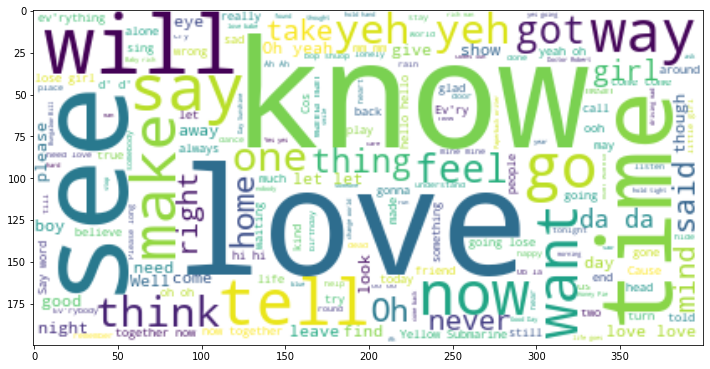

In [10]:
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', max_words=800).generate(" ".join(data["Lyrics"]))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()

Not surprisingly, the most common word in the lexicon of the Beatles is Love.

###The probability of the words over the years

Aside from the fact that the Beatles composed the most beautiful songs ever heard, the other element that made the Beatles the most influential band in history, is the shift from simple blues songs to a new invention of a new genre in music - progressive and psychedelic rock. I am interested in examining the change that has taken place over the years in the lyrics.  
**Note:** It is important to remove stop words and punctuation from the words, as they appear very frequently but are not semantically significant. I also removed the words: 'yeah','yeh' and 'oh'. 

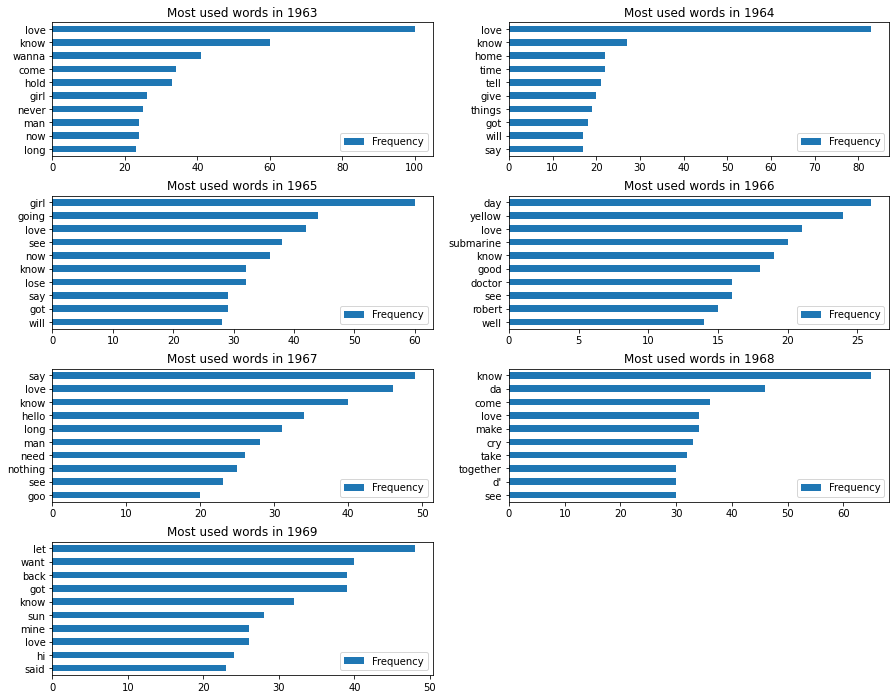

In [11]:
counts_dict = {}
words_to_ignore = STOPWORDS
other_words_to_take_out = ['-', '?',',','yeah','yeh','oh']
words_to_ignore.update(other_words_to_take_out)

for dt in data['Year'].unique():
    df = data.query('Year == @dt')
    text = df.Lyrics.apply(lambda x: x.lower().split()).tolist()
    text = [item.split(',')[0] for elem in text for item in elem]
    df1 = pd.Series(text).value_counts().to_frame().reset_index()
    df1.columns = ['Word', 'Frequency']
    df1 = df1[~df1.Word.isin(words_to_ignore)].head(10)
    df1 = df1.set_index("Word").sort_values(by = "Frequency", ascending = True)
    counts_dict[dt] = df1

plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.3)

keys = list(counts_dict.keys())
keys.sort()
for n, key in enumerate(keys):
    ax = plt.subplot(4, 2, n + 1)
    ax.set_title(f"Most used words in {key}")
    counts_dict[keys[n]].plot(ax=ax, kind = 'barh')
    plt.ylabel("")

plt.show()

Frequency of songs over the years:

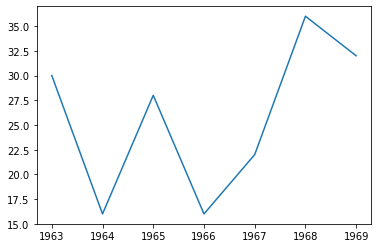

In [12]:
plt.plot(data.Year.value_counts(sort=False).sort_index())

###Tokenizing the lyrics

When dealing with text generation, we have several approaches into how to tokenize sentences. In this notebook, I will train the models using with 2 approaches:
1.   Character Tokenizing: tokenizing sentences so that each token is a char. The RNN will predict a char based on the previous chars in the sentence. 
2.   Words Tokenizing: tokenizing sentences so that each token is a word. The RNN will predict a word based on the previous words in the sentence. 

There is no exact answer as to which method we will put out more grammatically correct and more beautiful songs, so I will try to examine both methods.


###Spliting the data

In addition there is another dilemma we face: How to divide the data itself? 

1.   Dividing the data into sentences.
2.   Dividing the data sequentially.


In this dilemma we also have to take into account that the networks get sentences of a defined length. It means that if there is a shorter sentence than the defined length sentence, we will have to pad it 0 to fill in the missing part, and if the sentence is longer than the defined sentence length, we will have to cut parts of it.  

Lets take an example from the song 'A day in the life', written by John Lennon:  
*And though the news was rather sad\n,  
Well, I just had to laugh\n,  
I saw the photograph\n,  
He blew his mind out in a car\n*

If we choose the 1st approach, with a sentence length=8, our data may look like this:  
- ['And' , 'though' , 'the' , 'news' , 'was' , 'rather' , 'sad' ,'\n'] , Target='Well'
- ['Well' , 'I' , 'just' , 'had' , 'to' , 'laugh' , '\n' , 0 ] , Target='I'
- ['I' , 'saw' , 'the' , 'photograph' , '\n' , 0 , 0 , 0 ] , Target = 'He' 

In the other hand, If we choose the 2nd approach (when step=4):  
- ['And' , 'though' , 'the' , 'news' , 'was' , 'rather' , 'sad' ,'\n'] , Target='Well'
- ['news' , 'was' , 'rather' , 'sad' ,'\n' , 'Well' , 'I' , 'just' ] , Target='had'
- ['sad' ,'\n' , 'Well' , 'I' , 'just' , 'had' , 'to' , 'laugh' ] , Target='\n'

I don't want the model to get a lot of '0' in his training and I also don't want to cut back on sentences. In addition, I would also like the token '\n' to be involved in the all parts of the sentence, so that he will be able to understand the structure of songs. Therefore, I decided to choose the second approach and divide the data sequentially.  
I will consider trying to test the first approach too later.

The data spliting method (sequentially):

In [13]:
def split_data(CHAR_WINDOW,STEP,corpus):
  sentences = []
  targets = []
  for i in range(0, len(corpus) - CHAR_WINDOW, STEP):
    sentences.append(corpus[i:i+CHAR_WINDOW])
    targets.append(corpus[i + CHAR_WINDOW])

  df = pd.DataFrame({'sentence': sentences, 'targets': targets})
  print(df.head())
  return sentences,targets

#Character Tokenizing Training

##Data Pre-Process

Lets start with tokenizing the corpus by chars, sequentially.

In [14]:
Corpus =''
for listitem in data.Lyrics:
    Corpus += listitem
    Corpus += '\n'

VOCAB_LENGTH = len(set(Corpus.lower()))
print("The unique characters: \n",sorted(set(Corpus.lower())))
print("Number of unique characters:", VOCAB_LENGTH)

The unique characters: 
 ['\n', ' ', '!', '"', '&', "'", '(', ')', ',', '-', '.', ':', ';', '?', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'é']
Number of unique characters: 43


For tokenzing tasks (in both char and word tokenizing), we will use the keras pre processing tokenizer.  
We will set the 'char_level' parameter to True and fit the tokenizer to the corpus. By doing that, we will create dictionaries to map our tokens (index to words and words to index). 

In [15]:
tokenizer = Tokenizer(filters='',lower=True,char_level=True)
tokenizer.fit_on_texts(Corpus)

I decided to use window length=15 and step=2.

In [16]:
CHAR_WINDOW = 15
STEP = 2
corpus_splited_to_chars = [char for char in Corpus.lower()]
sentences,targets = split_data(CHAR_WINDOW,STEP,corpus_splited_to_chars)

                                        sentence targets
0  [c, a, n, ', t,  , b, u, y,  , m, e,  , l, o]       v
1  [n, ', t,  , b, u, y,  , m, e,  , l, o, v, e]       ,
2  [t,  , b, u, y,  , m, e,  , l, o, v, e, ,,  ]       o
3  [b, u, y,  , m, e,  , l, o, v, e, ,,  , o, h]       ,
4  [y,  , m, e,  , l, o, v, e, ,,  , o, h, ,,  ]       l


Great. Now lets transform the sentences and the targets we have got into numbers, by using the keras tokenizer 'text_to_sequences' method:

In [17]:
seqs_numeric = tokenizer.texts_to_sequences(sentences)
targets_numeric = tokenizer.texts_to_sequences(targets)

Let's transform the numbers obtained from each token into a one-hot vector.
The reason for this change consists of a host of benefits. One of them is related to distances.  
Suppose some of our models predicted a token whose index is 30, but in practice, the correct token(the target) is a token whose index is 34. If we won't transform the indexes to one-hot vectors, in the backpropagation phase we will "show" the model that the difference between the predicted token and the target token is 4. This assumption is incorrect, because the difference between the tokens is equal. There is no real difference between the word 'the' for example and the word 'one'.  By applying this transformation, we make sure that the tokens have the same distances from each other.  
**Note**: When we will get to word tokenizing, we will use words embeddings that will be later explained.

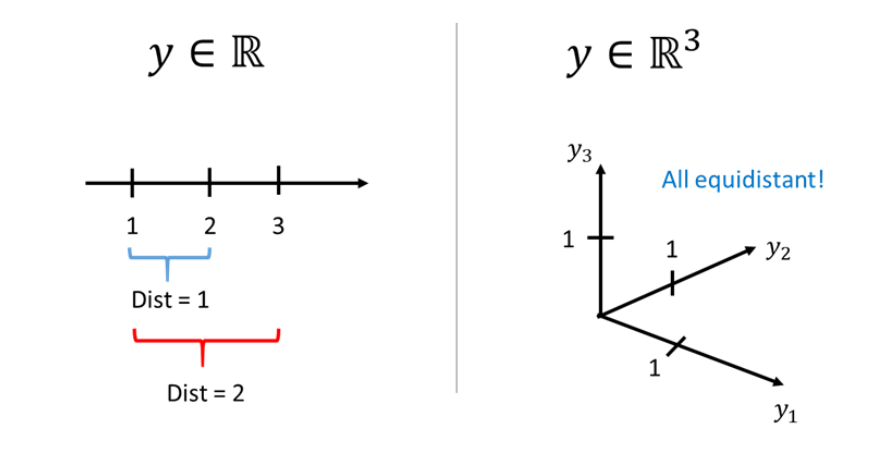

In [18]:
def create_vectors_for_setences(num_seqs,chars_window,n_vocab,sentences,targets,test=False):
  numerical_sentences = np.zeros((num_seqs, chars_window, n_vocab+1))
  numerical_next_chars = np.zeros((num_seqs, n_vocab+1))

  # Loop for every sentence
  for i, sentence in enumerate(sentences):
    # Loop for every character in sentence
    for t, char in enumerate(sentence):
      # Set position of the character to 1
      numerical_sentences[i, t, char] = 1
      # Set next character to 1
    
    if test == True:
      return numerical_sentences
          
    numerical_next_chars[i, targets[i]] = 1

  return numerical_sentences,numerical_next_chars   


In [19]:
num_seqs = len(sentences)
texts_vectorized,targets_vectorized = create_vectors_for_setences(num_seqs,CHAR_WINDOW,VOCAB_LENGTH,seqs_numeric,targets_numeric)
input_shape = texts_vectorized.shape[1:3]

The last method in the pre-processing is the lyrics generator method. It will be used for both char and word tokenization. The parameter by_char determinates whether we are using char or word predictions. The starting_seq parameter is the starting of the song that we want the model to write.

In [20]:
def lyrics_generator(model,starting_seq,size,by_char=True):
  for i in range(size):
    if by_char==True:
      seq_splited = [char for char in starting_seq.lower()]
    else:
      seq_splited = pre_process_for_words(starting_seq)
      seq_splited = seq_splited.split(' ')

    seq_numeric = tokenizer.texts_to_sequences(seq_splited)
    seq_numeric = [item for sublist in seq_numeric for item in sublist]
    seq_numeric = pad_sequences([seq_numeric],maxlen=CHAR_WINDOW,padding='pre',truncating='pre')
    if by_char==True:
      seq_to_model = create_vectors_for_setences(1,15,VOCAB_LENGTH,seq_numeric,_,test=True)
    else:
      seq_to_model = seq_numeric  
    predictions =  model.predict(seq_to_model)
    index = np.argmax(predictions)
    char_word = tokenizer.index_word[index]
    if by_char==True:
      starting_seq += char_word
    else:
      starting_seq = starting_seq + ' ' + char_word  

  return starting_seq

#Training

For better training, we will use the Keras tuner for optimizing hyper-parameters. The hyper-parameters we will test will be the dropout rate and the learning rate value, using the Hyperband tuner. A train-validation split will only be applied in the hyper-parameters tuning but not in the whole training (explained below). I will use 'EarlyStopping' for stopping the model to continuing training after no improvement, 'ReduceLROnPlateau' for decreasing the loss after no big improvement, and 'ModelCheckpoint' for saving the best model in my drive. 

###Evaluation

I will not use any metric for evaluation, because there is no exact metric of a song's quality/beauty or its correct grammar. Beauty is a metric determined by the subjective person. My only hope is that the model will understand the grammar rules, because, for me, it is a must for a song to become beautiful, but maybe some people will find beauty in grammatically wrong songs. I cannot answer it for sure.

A train-validation split will only be applied in the hyper-parameters tuning but not in the whole training. The reason for that lies in the answer to the question: What does it mean to have a good training rate and a bad validation rate in our case? What does overfit mean for us in this task? Is it necessarily mean that our model is bad and won`t be able to able to produce great lyrics?
We may have a training set that contains a sentence - 'she' with a target - 'loves', and a validation set that contains a sentence - 'she' with a target 'wants'. If the model will predict the word 'loves' after 'she' and not 'wants', will it be necessarily wrong? No. Both predictions make sense in this case. I will still use a training-validation split when tuning the models only for a little bit of intuition, but in the training I want the model to "see" all the options of sentences the Beatles have written.

##1st Model

Lets use a SimpleRNN architecture for a start.

In [22]:
def build_model(hp):
  model = Sequential()
  hp_drop = hp.Choice('dropout_rate',values=[0.0,0.1,0.15,0.2])
  model.add(SimpleRNN(units=128, input_shape= input_shape , return_sequences=False, name="Input_layer",dropout=hp_drop))
  model.add(Dense(VOCAB_LENGTH+1, activation='softmax', name="Output_layer"))
  hp_learning_rate = hp.Choice('learning_rate',values=[0.1,0.01,0.001])
  opt = keras.optimizers.Adam(learning_rate=hp_learning_rate, )
  model.compile(loss='categorical_crossentropy', optimizer=opt)
  return model

In [24]:
tuner = kt.Hyperband(build_model,objective='val_loss',max_epochs=12)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(texts_vectorized, targets_vectorized, epochs=50, validation_split=0.2, callbacks=[stop_early])
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Optimal Drop out rate is: {best_hps.get('dropout_rate')} \n
Optimal Learning rate is: {best_hps.get('learning_rate')}.
""")


Optimal Drop out rate is: 0.0 

Optimal Learning rate is: 0.001.



In [45]:
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (SimpleRNN)     (None, 128)               22144     
                                                                 
 Output_layer (Dense)        (None, 44)                5676      
                                                                 
Total params: 27,820
Trainable params: 27,820
Non-trainable params: 0
_________________________________________________________________


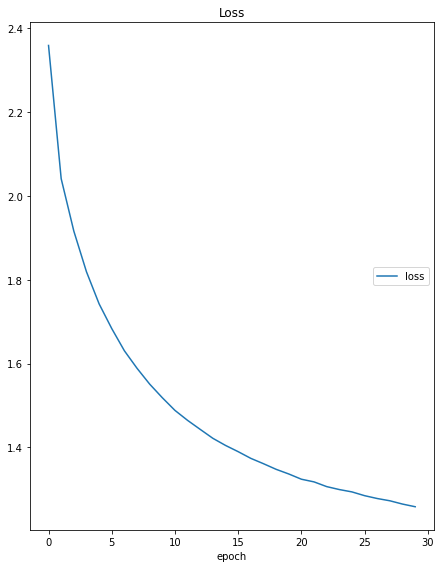

Loss
	loss             	 (min:    1.259, max:    2.359, cur:    1.259)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Beatles Models/SimpleRNN_1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Beatles Models/SimpleRNN_1/assets


2266/2266 - 21s - loss: 1.2586 - lr: 0.0010 - 21s/epoch - 9ms/step


In [40]:
earlyStopping = EarlyStopping(monitor='loss', patience=5, verbose=0, mode='min')
mcp_save = ModelCheckpoint('/content/drive/MyDrive/Beatles Models/SimpleRNN_1', save_best_only=True, monitor='loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, verbose=1, min_delta=0.01, mode='min')
history = model.fit(x=texts_vectorized,y=targets_vectorized,epochs=30,verbose=2,
                 callbacks=[PlotLossesKeras(),earlyStopping,mcp_save,reduce_lr_loss],shuffle=True)

Results:

In [41]:
model = keras.models.load_model('/content/drive/MyDrive/Beatles Models/SimpleRNN_1')
string = lyrics_generator(model,"let it",300)
print(string)

let it be
and i think it in the man
i want you i want you i want you i want you i want you i want you i want you i want you i want you i want you i want you i want you i want you i want you i want you i want you i want you i want you i want you i want you i want you i want you i want you i want you i want


In [42]:
string = lyrics_generator(model,"the",300)
print(string)

ther need it is so sing a want to be the bat you we love you
you've got a way

i think of the thing

and i say you'll never be the car
so - you'll be tome's good make you tere you tell you to be the thing the words and i don't know why you say you're going to lose the words and i don't know why you say


Not too bad for a start. We can see that the model tend to repeat himself.

##2nd Model

Lets use 64 units of GRU.

In [21]:
def build_model(hp):
  model = Sequential()
  hp_drop = hp.Choice('dropout_rate',values=[0.0,0.1,0.15,0.2])
  model.add(GRU(units=64,dropout=hp_drop, input_shape= input_shape , return_sequences=False, name="Input_layer"))
  model.add(Dense(VOCAB_LENGTH+1, activation='softmax', name="Output_layer"))
  hp_learning_rate = hp.Choice('learning_rate',values=[0.1,0.01,0.001])
  opt = keras.optimizers.Adam(learning_rate=hp_learning_rate, )
  model.compile(loss='categorical_crossentropy', optimizer=opt)
  return model

In [25]:
tuner = kt.Hyperband(build_model,objective='val_loss',max_epochs=50,overwrite=True)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(texts_vectorized,targets_vectorized,epochs=50, validation_split=0.2, callbacks=[stop_early])
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Optimal Drop out rate is: {best_hps.get('dropout_rate')} \n
Optimal Learning rate is: {best_hps.get('learning_rate')}.
""")

Trial 12 Complete [00h 00m 15s]
val_loss: 1.9159690141677856

Best val_loss So Far: 1.9050403833389282
Total elapsed time: 00h 03m 16s
INFO:tensorflow:Oracle triggered exit

Optimal Drop out rate is: 0.0 

Optimal Learning rate is: 0.01.



In [26]:
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (GRU)           (None, 64)                21120     
                                                                 
 Output_layer (Dense)        (None, 44)                2860      
                                                                 
Total params: 23,980
Trainable params: 23,980
Non-trainable params: 0
_________________________________________________________________


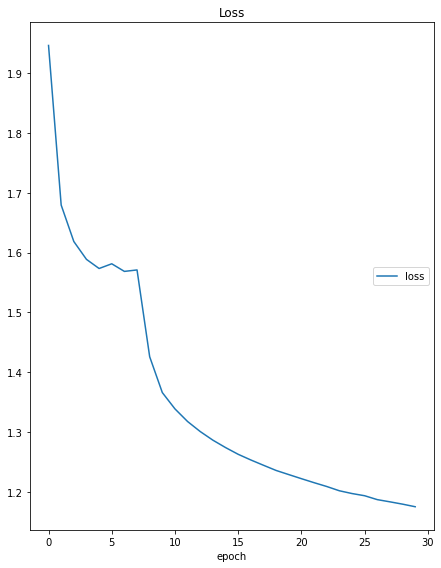

Loss
	loss             	 (min:    1.175, max:    1.947, cur:    1.175)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Beatles Models/GRU_1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Beatles Models/GRU_1/assets


2266/2266 - 10s - loss: 1.1750 - lr: 1.0000e-03 - 10s/epoch - 4ms/step


In [27]:
earlyStopping = EarlyStopping(monitor='loss', patience=5, verbose=0, mode='min')
mcp_save = ModelCheckpoint('/content/drive/MyDrive/Beatles Models/GRU_1', save_best_only=True, monitor='loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, verbose=1, min_delta=0.01, mode='min')
history = model.fit(x=texts_vectorized,y=targets_vectorized,epochs=30,verbose=2,
                 callbacks=[PlotLossesKeras(),earlyStopping,mcp_save,reduce_lr_loss],shuffle=True)

**Note:** We can notice the power of the learing rate reducion in epochs 5-10.

Results:

In [29]:
model = keras.models.load_model('/content/drive/MyDrive/Beatles Models/GRU_1')
string = lyrics_generator(model,"One",300)
print(string)

One to be the sun
just love me to me
i want you all her the world me the sun
just love me to me
i want you all her the world me the sun
just love me to me
i want you all her the world me the sun
just love me to me
i want you all her the world me the sun
just love me to me
i want you all her the world m


In [22]:
string = lyrics_generator(model,"",300)
print(string)

art i want to let me to be long the sun
just love me to me
i want you all her the world me the sun
just love me to me
i want you all her the world me the sun
just love me to me
i want you all her the world me the sun
just love me to me
i want you all her the world me the sun
just love me to me
i wan


The model is repeating himself.

##3rd Model

Lets try two layers of 64 units of LSTM.

In [30]:
def build_model(hp):
  model = Sequential()
  hp_drop = hp.Choice('dropout_rate',values=[0.0,0.1,0.15,0.2])
  model.add(LSTM(64, input_shape=input_shape, dropout=hp_drop, return_sequences=True, name="Input_layer"))
  model.add(LSTM(64, dropout=hp_drop, return_sequences=False, name="LSTM_hidden"))
  model.add(Dense(VOCAB_LENGTH+1, activation='softmax', name="Output_layer"))
  hp_learning_rate = hp.Choice('learning_rate',values=[0.1,0.01,0.001])
  opt = keras.optimizers.Adam(learning_rate=hp_learning_rate)
  model.compile(loss='categorical_crossentropy', optimizer=opt)
  return model

In [31]:
tuner = kt.Hyperband(build_model,objective='val_loss',max_epochs=50,overwrite=True)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(texts_vectorized,targets_vectorized,epochs=50, validation_split=0.2, callbacks=[stop_early])
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Optimal Drop out rate is: {best_hps.get('dropout_rate')} \n
Optimal Learning rate is: {best_hps.get('learning_rate')}.
""")

Trial 12 Complete [00h 00m 23s]
val_loss: 3.039010524749756

Best val_loss So Far: 1.8183274269104004
Total elapsed time: 00h 05m 09s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit



Optimal Drop out rate is: 0.0 

Optimal Learning rate is: 0.01.



In [32]:
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (LSTM)          (None, 15, 64)            27904     
                                                                 
 LSTM_hidden (LSTM)          (None, 64)                33024     
                                                                 
 Output_layer (Dense)        (None, 44)                2860      
                                                                 
Total params: 63,788
Trainable params: 63,788
Non-trainable params: 0
_________________________________________________________________


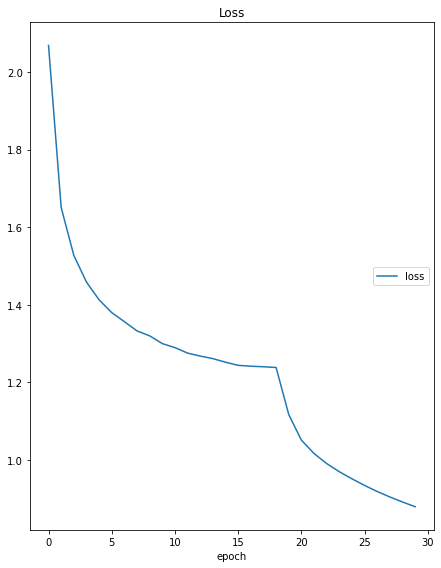

Loss
	loss             	 (min:    0.879, max:    2.068, cur:    0.879)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Beatles Models/LSTM_1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Beatles Models/LSTM_1/assets


2266/2266 - 17s - loss: 0.8795 - lr: 1.0000e-03 - 17s/epoch - 7ms/step


In [33]:
earlyStopping = EarlyStopping(monitor='loss', patience=5, verbose=0, mode='min')
mcp_save = ModelCheckpoint('/content/drive/MyDrive/Beatles Models/LSTM_1', save_best_only=True, monitor='loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, verbose=1, min_delta=0.01, mode='min')
history = model.fit(x=texts_vectorized,y=targets_vectorized,epochs=30,verbose=2,
                 callbacks=[PlotLossesKeras(),earlyStopping,mcp_save,reduce_lr_loss],shuffle=True)

In [23]:
model = keras.models.load_model('/content/drive/MyDrive/Beatles Models/LSTM_1')

Results:

In [38]:
string = lyrics_generator(model,"love",300)
print(string)

lovelled my way
i'm try me wrong to love

i want you i want you i want you i want you i want you i want you i want you i want you i want you i want you i want you i want you i want you i want you i want you i want you i want you i want you i want you i want you i want you i want you i want you i want yo


In [24]:
string = lyrics_generator(model,"",300)
print(string)

er the world that i'm gonna be the sun, here to love

i want you i want you i want you i want you i want you i want you i want you i want you i want you i want you i want you i want you i want you i want you i want you i want you i want you i want you i want you i want you i want you i want you i wa


No better results than the first two.

# Word Tokenizing Training

##Data pre-process

This method is for making the '\n' and punctuation tokens as well.

In [21]:
def pre_process_for_words(corpus):
  new_corpus = corpus.replace('\n',' \n ')
  new_corpus = new_corpus.replace(',',' , ')
  new_corpus = new_corpus.replace('!',' ! ')
  new_corpus = new_corpus.replace('.',' . ')
  new_corpus = new_corpus.replace('-',' - ')
  new_corpus = new_corpus.replace('(',' ( ')
  new_corpus = new_corpus.replace(')',' ) ')
  new_corpus = new_corpus.replace('[',' [ ')
  new_corpus = new_corpus.replace(']',' ] ')
  return new_corpus

In [22]:
new_corpus = pre_process_for_words(Corpus)
tokenizer = Tokenizer(filters='',lower=True)
tokenizer.fit_on_texts([new_corpus])

Char Window is 15 here as well and step is 2.

In [23]:
CHAR_WINDOW = 15
STEP = 2
VOCAB_LENGTH = len(tokenizer.index_word)

corpus_splited_to_seq = new_corpus.split(' ')
corpus_splited_to_seq = [x for x in corpus_splited_to_seq if x!='']
sentences,targets = split_data(CHAR_WINDOW,STEP,corpus_splited_to_seq)

                                            sentence targets
0  [Can't, buy, me, love, ,, oh, ,, love, ,, oh, ...       ,
1  [me, love, ,, oh, ,, love, ,, oh, \n, Can't, b...      \n
2  [,, oh, ,, love, ,, oh, \n, Can't, buy, me, lo...     buy
3  [,, love, ,, oh, \n, Can't, buy, me, love, ,, ...       a
4  [,, oh, \n, Can't, buy, me, love, ,, oh, \n, I...    ring


Here I am transform the sentences to numbers and the targets to a one-hot vector.

In [24]:
seqs_numeric = tokenizer.texts_to_sequences(sentences)
targets_numeric = tokenizer.texts_to_sequences(targets)
texts_vectorized = np.zeros((len(seqs_numeric),CHAR_WINDOW),dtype='int32')
targets_vectorized = np.zeros((len(seqs_numeric),VOCAB_LENGTH),dtype='int32')

for i,seq in enumerate(seqs_numeric):
  texts_vectorized[i] = seqs_numeric[i]
  index = targets_numeric[i][0]
  targets_vectorized[i, targets_numeric[i][0]] = 1

##The Embeddings
Word embedding is a term used for the representation of words for text analysis, typically in the form of a real-valued vector that encodes the meaning of the word such that the words that are closer in the vector space are expected to be similar in meaning(from wikipedia).  
Just like we represented a char as a one-hot vector, here we will represent words with 100-300 dimension vectors.  
There are already several prepared embeddings. We will use the GloVe embeddings(https://nlp.stanford.edu/projects/glove/). Later, we will train our own embeddings layer and see the results. 

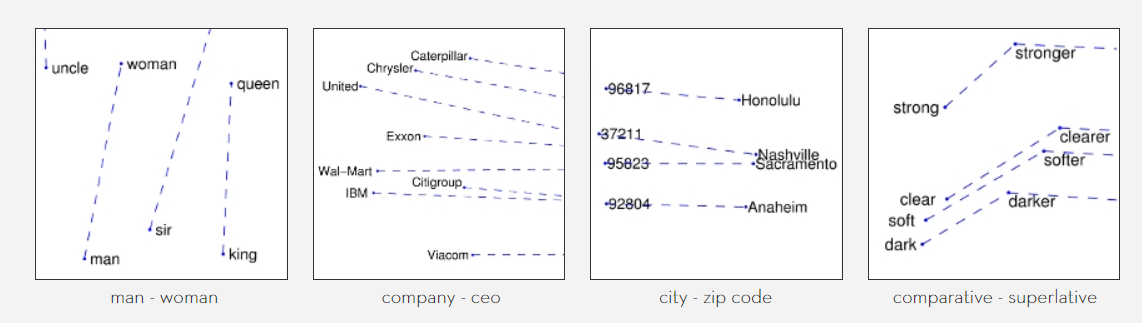

Downloading the GloVe embeddings:

In [25]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-01-24 09:13:06--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-01-24 09:13:07--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-01-24 09:13:07--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [26]:
!unzip -q glove.6B.zip

In [27]:
path_to_glove_file = '/content/glove.6B.200d.txt'
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))


Found 400000 word vectors.


Lets see how much words from our vocab are represented in the GloVe embeddings:

In [28]:
embedding_dim = 200
hits = 0
misses = 0

embedding_matrix = np.zeros((VOCAB_LENGTH+1, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 2153 words (216 misses)


Good enough.

##1st Model

In [31]:
def build_model(hp):
  model = Sequential()
  hp_drop = hp.Choice('dropout_rate',values=[0.0,0.1,0.15,0.2])
  model.add(Embedding(input_dim=VOCAB_LENGTH+1, output_dim=embedding_dim,embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                    trainable=False,input_length=CHAR_WINDOW))
  model.add(SimpleRNN(units=128,dropout=hp_drop))
  model.add(Dense(VOCAB_LENGTH, activation='softmax'))
  hp_learning_rate = hp.Choice('learning_rate',values=[0.1,0.01,0.001])
  opt = keras.optimizers.Adam(learning_rate=hp_learning_rate)
  model.compile(loss='categorical_crossentropy', optimizer=opt)
  return model

In [32]:
tuner = kt.Hyperband(build_model,objective='val_loss',max_epochs=50,overwrite=True)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(texts_vectorized,targets_vectorized,epochs=50, validation_split=0.2, callbacks=[stop_early])
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Optimal Drop out rate is: {best_hps.get('dropout_rate')} \n
Optimal Learning rate is: {best_hps.get('learning_rate')}.
""")

Trial 11 Complete [00h 00m 13s]
val_loss: 5.566557884216309

Best val_loss So Far: 5.512677192687988
Total elapsed time: 00h 02m 33s
INFO:tensorflow:Oracle triggered exit

Optimal Drop out rate is: 0.0 

Optimal Learning rate is: 0.001.



In [38]:
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 15, 200)           474000    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 128)               42112     
                                                                 
 dense_2 (Dense)             (None, 2369)              305601    
                                                                 
Total params: 821,713
Trainable params: 347,713
Non-trainable params: 474,000
_________________________________________________________________


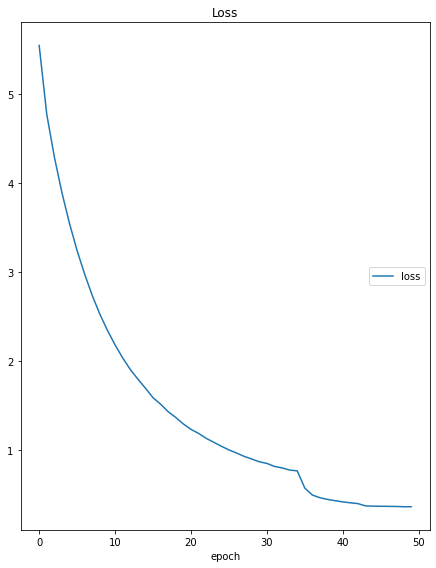

Loss
	loss             	 (min:    0.358, max:    5.551, cur:    0.358)
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Beatles Models/SimpleRNN_2/assets
577/577 - 10s - loss: 0.3581 - lr: 1.0000e-06 - 10s/epoch - 17ms/step


In [39]:
earlyStopping = EarlyStopping(monitor='loss', patience=5, verbose=0, mode='min')
mcp_save = ModelCheckpoint('/content/drive/MyDrive/Beatles Models/SimpleRNN_2', save_best_only=True, monitor='loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, verbose=1, min_delta=0.06, mode='min')
history = model.fit(x=texts_vectorized,y=targets_vectorized,epochs=50,verbose=2,
                 callbacks=[PlotLossesKeras(),earlyStopping,mcp_save,reduce_lr_loss],shuffle=True)

In [22]:
model = keras.models.load_model('/content/drive/MyDrive/Beatles Models/SimpleRNN_2')

In [34]:
string = lyrics_generator(model,'Lucy in the sky',100,by_char=False)
print(string)

Lucy in the sky is having 
 i'd in the eyes are 
 they're now you're to a little girl , 
 the one i think it's you once there 
 i don't go you don't i want you i want you so bad 
 i want you i want you so bad 
 it's driving me mad it's driving me mad 
 i want you i want you so bad babe 
 i want you i want you so bad 
 it's driving me mad it's driving me mad 
 i want you i want you so bad babe 
 i want you


In [32]:
string = lyrics_generator(model,'In my life',130,by_char=False)
print(string)

In my life if i can show you go 
 it is just and i hear it 
 
 let me love you 
 
 you told me once more 
 all what wrong to me 
 i can't concieve you may ooh 
 
 i hi hi hi hi 
 dig your mind aches 
 you're coming on , come on 
 come on 
 that i don't well to me is 
 i need you love you more boy 
 'cause the boy 
 knowing he he had a day 
 that i was dream of things i know 
 it's got i'm in the way that things to me . 
 i have no you can ooh 
 ( birthday ) till say much as from to take 
 it's


The results look better than the results of the chars prediction models.

##2nd Model

In [39]:
def build_model(hp):
  model = Sequential()
  hp_drop = hp.Choice('dropout_rate',values=[0.0,0.1,0.15,0.2])
  model.add(Embedding(input_dim=VOCAB_LENGTH+1, output_dim=embedding_dim,embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                    trainable=False,input_length=CHAR_WINDOW))
  model.add(LSTM(128, input_shape=input_shape, dropout=hp_drop, return_sequences=False, name="LSTM_layer"))
  model.add(Dense(VOCAB_LENGTH, activation='softmax', name="Output_layer"))
  hp_learning_rate = hp.Choice('learning_rate',values=[0.1,0.01,0.001])
  opt = keras.optimizers.Adam(learning_rate=hp_learning_rate)
  model.compile(loss='categorical_crossentropy', optimizer=opt)
  return model

In [40]:
tuner = kt.Hyperband(build_model,objective='val_loss',max_epochs=50,overwrite=True)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(texts_vectorized,targets_vectorized,epochs=50, validation_split=0.2, callbacks=[stop_early])
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Optimal Drop out rate is: {best_hps.get('dropout_rate')} \n
Optimal Learning rate is: {best_hps.get('learning_rate')}.
""")

Trial 11 Complete [00h 00m 07s]
val_loss: 6.256006717681885

Best val_loss So Far: 5.533555507659912
Total elapsed time: 00h 01m 10s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit



Optimal Drop out rate is: 0.2 

Optimal Learning rate is: 0.01.



In [41]:
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 15, 200)           474000    
                                                                 
 LSTM_layer (LSTM)           (None, 128)               168448    
                                                                 
 Output_layer (Dense)        (None, 2369)              305601    
                                                                 
Total params: 948,049
Trainable params: 474,049
Non-trainable params: 474,000
_________________________________________________________________


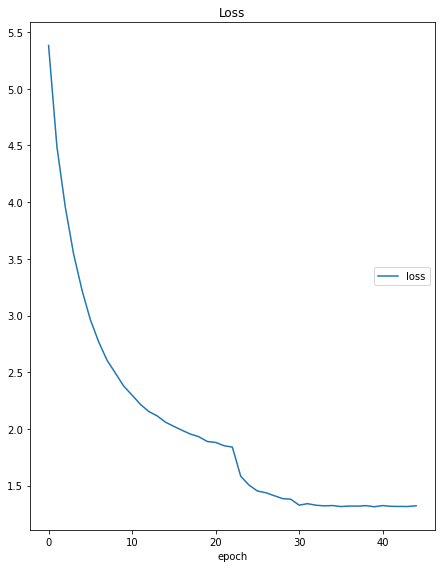

Loss
	loss             	 (min:    1.314, max:    5.382, cur:    1.322)
577/577 - 2s - loss: 1.3220 - lr: 1.0000e-08 - 2s/epoch - 3ms/step


In [42]:
earlyStopping = EarlyStopping(monitor='loss', patience=5, verbose=0, mode='min')
mcp_save = ModelCheckpoint('/content/drive/MyDrive/Beatles Models/LSTM_2', save_best_only=True, monitor='loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, verbose=1, min_delta=0.06, mode='min')
history = model.fit(x=texts_vectorized,y=targets_vectorized,epochs=50,verbose=2,
                 callbacks=[PlotLossesKeras(),earlyStopping,mcp_save,reduce_lr_loss],shuffle=True)

In [43]:
model = keras.models.load_model('/content/drive/MyDrive/Beatles Models/LSTM_2')

In [46]:
string = lyrics_generator(model,'',130,by_char=False)
print(string)

 of the english , sgt . pepper's lonely hearts club band 
 
 wonderful to say that i don't believe 
 there's happened to think to say 
 you're live with you to know 
 that is really 
 matter what i don't would what i don't sleep 
 i can't stop my brain 
 you know i love you 
 so i told them all pulled out 
 see how they'll run yeh 
 she loves you yeh , yeh 
 she loves you yeh , yeh 
 she loves you yeh , yeh 
 she loves you yeh , yeh 
 she loves you yeh , yeh 
 she loves you yeh , yeh 
 she loves you yeh , yeh 
 she loves you yeh , yeh


In [50]:
string = lyrics_generator(model,'hey jude',200,by_char=False)
print(string)

hey jude don't make me half you into your head 
 found in the ussr 
 you come on , let me that you want me that you want 
 like you are 
 sexy sadie ooh you know how hard it makes me 
 
 you know that you want me that i need you 
 strawberry fields forever 
 and i love you 
 and i love you 
 
 always took me 
 oh - yes i'm falling 
 and i saw her standing there 
 
 got a chance with you 
 i'm just to dance with you 
 i got a man named a long long long long long ago 
 your mother's opaque 
 if the sun shines , 
 
 the kind of the world it's yes me , i do you so bad 
 it's driving me mad it's driving me mad 
 ( all you've feeling sorry the same old line 
 i'm wond'ring why don't really matter we said today 
 
 you know that you know what can be 
 they way of things are 
 and i want you so bad 
 it's driving me mad it's driving me mad


The model is combining words from different songs: 'Sgt.pepper's lonely hearts club band' , 'Strawberry fields forever', 'Back in the USSR', 'I saw her standing there' and more. That may be the best results we got so far.

Lets conitune with this architecture and add more 128 LSTM units.

##3rd Model

In [29]:
def build_model(hp):
  model = Sequential()
  hp_drop = hp.Choice('dropout_rate',values=[0.0,0.1,0.15,0.2])
  model.add(Embedding(input_dim=VOCAB_LENGTH+1, output_dim=embedding_dim,embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                    trainable=False,input_length=CHAR_WINDOW))
  model.add(LSTM(256, input_shape=input_shape, dropout=hp_drop, return_sequences=False, name="LSTM_layer"))
  model.add(Dense(VOCAB_LENGTH, activation='softmax', name="Output_layer"))
  hp_learning_rate = hp.Choice('learning_rate',values=[0.1,0.01,0.001])
  opt = keras.optimizers.Adam(learning_rate=hp_learning_rate)
  model.compile(loss='categorical_crossentropy', optimizer=opt)
  return model

In [30]:
tuner = kt.Hyperband(build_model,objective='val_loss',max_epochs=50,overwrite=True)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(texts_vectorized,targets_vectorized,epochs=50, validation_split=0.2, callbacks=[stop_early])
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Optimal Drop out rate is: {best_hps.get('dropout_rate')} \n
Optimal Learning rate is: {best_hps.get('learning_rate')}.
""")

Trial 11 Complete [00h 00m 07s]
val_loss: 5.536636829376221

Best val_loss So Far: 5.4910502433776855
Total elapsed time: 00h 01m 25s
INFO:tensorflow:Oracle triggered exit

Optimal Drop out rate is: 0.0 

Optimal Learning rate is: 0.001.



In [36]:
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 15, 200)           474000    
                                                                 
 LSTM_layer (LSTM)           (None, 256)               467968    
                                                                 
 Output_layer (Dense)        (None, 2369)              608833    
                                                                 
Total params: 1,550,801
Trainable params: 1,076,801
Non-trainable params: 474,000
_________________________________________________________________


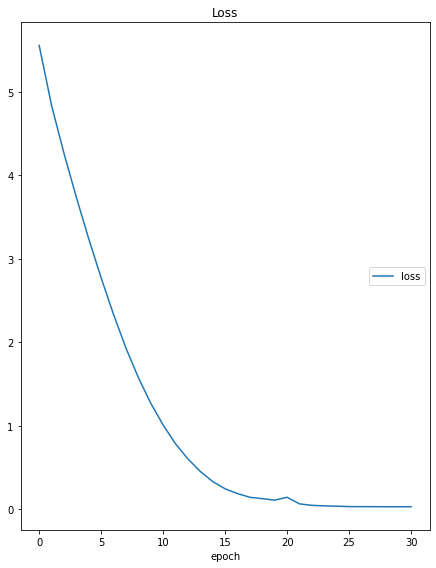

Loss
	loss             	 (min:    0.031, max:    5.556, cur:    0.031)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Beatles Models/LSTM_3/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Beatles Models/LSTM_3/assets



Epoch 00031: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
577/577 - 8s - loss: 0.0314 - lr: 1.0000e-06 - 8s/epoch - 14ms/step


In [37]:
earlyStopping = EarlyStopping(monitor='loss',min_delta=0.03, patience=5, verbose=0, mode='min')
mcp_save = ModelCheckpoint('/content/drive/MyDrive/Beatles Models/LSTM_3', save_best_only=True, monitor='loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, verbose=1, min_delta=0.06, mode='min')
history = model.fit(x=texts_vectorized,y=targets_vectorized,epochs=50,verbose=2,
                 callbacks=[PlotLossesKeras(),earlyStopping,mcp_save,reduce_lr_loss],shuffle=True)

In [42]:
model = keras.models.load_model('/content/drive/MyDrive/Beatles Models/LSTM_3')
string = lyrics_generator(model,'',250,by_char=False)
print(string)

 , trés took my down 
 she's gonna down down the ground 
 where it with her eyes 
 and his nowhere still makes it be 
 dream of her tonight is speaking 
 there one you and in the 
 i can hear it is 
 but you know what you want to do to do 
 i'm you know it's gonna do 
 but i'm the kind of me 
 there is all you want is love 
 and so you know 
 so hard to play 
 'cos i'm making to home with all their home 
 
 make an octopus's on a castiron 
 when i'm not one - a man 
 
 they said what you back in a fool of ev'ryone 
 it is no 
 i could never known a fool but 
 hide 
 oh yeah 
 
 well a glass onion and blue 
 
 my head in the sky 
 blue in a yellow submarine 
 and his his woman 
 lying in the corner in the world spinning round 
 when nobody to get to him , he not the place 
 i don't know what you're doing to me . 
 i want you to my head 
 only time , they get , get back to me 
 honey i know 
 better better 
 
 come my little away 
 i'm no time at all 
 now you're got a a time , 
 now to


##4th Model

In this model we will train our own embeddings and not use a known and prepared embeddings.

In [54]:
embedding_dim = 300
def build_model(hp):
  model = Sequential()
  hp_drop = hp.Choice('dropout_rate',values=[0.0,0.1,0.15,0.2])
  model.add(Embedding(input_dim=VOCAB_LENGTH+1, output_dim=embedding_dim,trainable=True,input_length=CHAR_WINDOW))
  model.add(LSTM(64, input_shape=input_shape, dropout=hp_drop, return_sequences=True, name="LSTM_layer"))
  model.add(LSTM(64, input_shape=input_shape, dropout=hp_drop, return_sequences=False, name="LSTM_layer2"))
  model.add(Dense(VOCAB_LENGTH, activation='softmax', name="Output_layer"))
  hp_learning_rate = hp.Choice('learning_rate',values=[0.1,0.01,0.001])
  opt = keras.optimizers.Adam(learning_rate=hp_learning_rate)
  model.compile(loss='categorical_crossentropy', optimizer=opt)
  return model

In [55]:
tuner = kt.Hyperband(build_model,objective='val_loss',max_epochs=50,overwrite=True)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(texts_vectorized,targets_vectorized,epochs=50, validation_split=0.2, callbacks=[stop_early])
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Optimal Drop out rate is: {best_hps.get('dropout_rate')} \n
Optimal Learning rate is: {best_hps.get('learning_rate')}.
""")

Trial 12 Complete [00h 00m 10s]
val_loss: 6.068143367767334

Best val_loss So Far: 5.720705986022949
Total elapsed time: 00h 02m 12s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit



Optimal Drop out rate is: 0.2 

Optimal Learning rate is: 0.01.



In [59]:
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 15, 300)           711000    
                                                                 
 LSTM_layer (LSTM)           (None, 15, 64)            93440     
                                                                 
 LSTM_layer2 (LSTM)          (None, 64)                33024     
                                                                 
 Output_layer (Dense)        (None, 2369)              153985    
                                                                 
Total params: 991,449
Trainable params: 991,449
Non-trainable params: 0
_________________________________________________________________


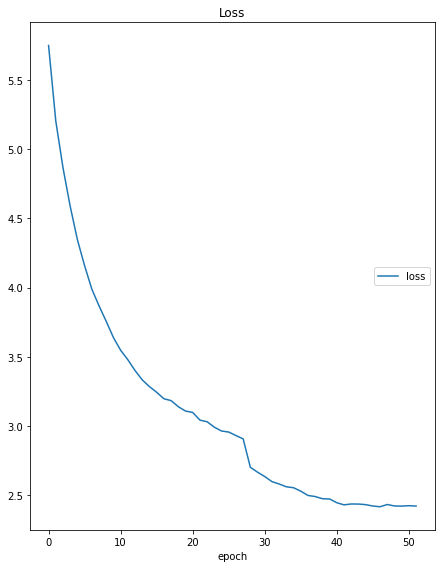

Loss
	loss             	 (min:    2.415, max:    5.751, cur:    2.420)
577/577 - 3s - loss: 2.4198 - lr: 1.0000e-07 - 3s/epoch - 5ms/step


In [60]:
earlyStopping = EarlyStopping(monitor='loss', patience=5, verbose=0, mode='min')
mcp_save = ModelCheckpoint('/content/drive/MyDrive/Beatles Models/LSTM_4', save_best_only=True, monitor='loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, verbose=1, min_delta=0.06, mode='min')
history = model.fit(x=texts_vectorized,y=targets_vectorized,epochs=80,verbose=2,
                 callbacks=[PlotLossesKeras(),earlyStopping,mcp_save,reduce_lr_loss],shuffle=True)

In [61]:
model = keras.models.load_model('/content/drive/MyDrive/Beatles Models/LSTM_4')

In [67]:
string = lyrics_generator(model,'',130,by_char=False)
print(string)

 
 and i will go for tea 
 and i will send it out 
 i said woof to play 
 i love you 
 i don't know why you say goodbye i love you 
 
 i told you so bad 
 i love you 
 i don't know why you say goodbye i love you 
 
 i told you so bad 
 i love you 
 i don't know why you say goodbye i love you 
 
 i told you so bad 
 i love you 
 i don't know why you say goodbye i love you 
 
 i told you so bad 
 i love you 
 i don't know why you say goodbye i love you 
 
 i told you so bad


Not better than the last one.

#Conclusion

It was nice to experiment with RNN networks, process the information for the networks and generate texts, even though the results were not as I expected. The networks did manage to create a text with sentences from the Beatles songs but there was not so much logic in the sentences and the grammar was not correct all the time. In any case, it can be seen from the results that adding a layer to the network will not necessarily help and create text that is less repetitive and creative than keeping just one layer. It is certainly possible to conclude that predicting words over predicting characters is preferable to creating more creative and logical texts and that using a prepared embedding matrix raises the quality of the results.

If you have any suggestions for improving the models or spot some mistakes, feel free to send me a message!

#Thoughts for the future

I will mostly delve into Generative adversarial networks(GAN) and explore them. I have seen some articles that suggest using these networks not only for creating new images but also for texts. I will research the subject further and try to use these networks for the creation of texts, in the hope that the text will have more quality.